In [1]:
import os
import cv2
import tqdm
import json
import numpy as np
import matplotlib.pyplot as plt

import torch
from torch.utils.data import Dataset, DataLoader
from torch.nn import Module, Sequential, Conv2d, AvgPool2d, GRU, Linear
from torch.nn.functional import ctc_loss, log_softmax
from torchvision import models

from string import digits, ascii_uppercase

np.random.seed(1234)

PATH_TO_DATA = f"/home/{os.environ['USER']}/datasets/recogn_car_plate" 
DEBUG = True
N_EPOCHS = 10
PATH_MODEL = "./crnn.pth.tar"


In [2]:
config_path = os.path.join(PATH_TO_DATA, "config.json")
images_path = os.path.join(PATH_TO_DATA, "images")
assert os.path.isfile(config_path)
assert os.path.isdir(images_path)

with open(config_path, "rt") as fp:
    config = json.load(fp)

config_full_paths = []
for item in config:
    config_full_paths.append(
        {"file": os.path.join(images_path, item["file"]), "text": item["text"]}
    )
config = config_full_paths

In [3]:
print("Total items in data:", len(config))
print("First 3 items:")
for item in config[:3]:
    print(item)

Total items in data: 41141
First 3 items:
{'file': '/home/ubuntu/datasets/recogn_car_plate/images/ru_typenomer7_180509_o_11307847.jpg', 'text': '8090TB76'}
{'file': '/home/ubuntu/datasets/recogn_car_plate/images/ru_typenomer2_190509_o_12834692.jpg', 'text': 'BA428416'}
{'file': '/home/ubuntu/datasets/recogn_car_plate/images/ru_typenomer12_160328_o_8249929.jpg', 'text': 'AA509A25'}


In [4]:
def show_tile(config, idxs, num_cols=5):
    num_rows = len(idxs) // num_cols + int(len(idxs) % num_cols != 0)
    plt.figure(figsize=(20, 2 * num_rows))
    for i, idx in enumerate(idxs, 1):
        item = config[idx]
        text = item["text"]
        image = cv2.imread(item["file"])
        plt.subplot(num_rows, num_cols, i)
        plt.imshow(image[:, :, ::-1])
        plt.title(text)
        plt.axis("off")

    plt.tight_layout()
    plt.show()

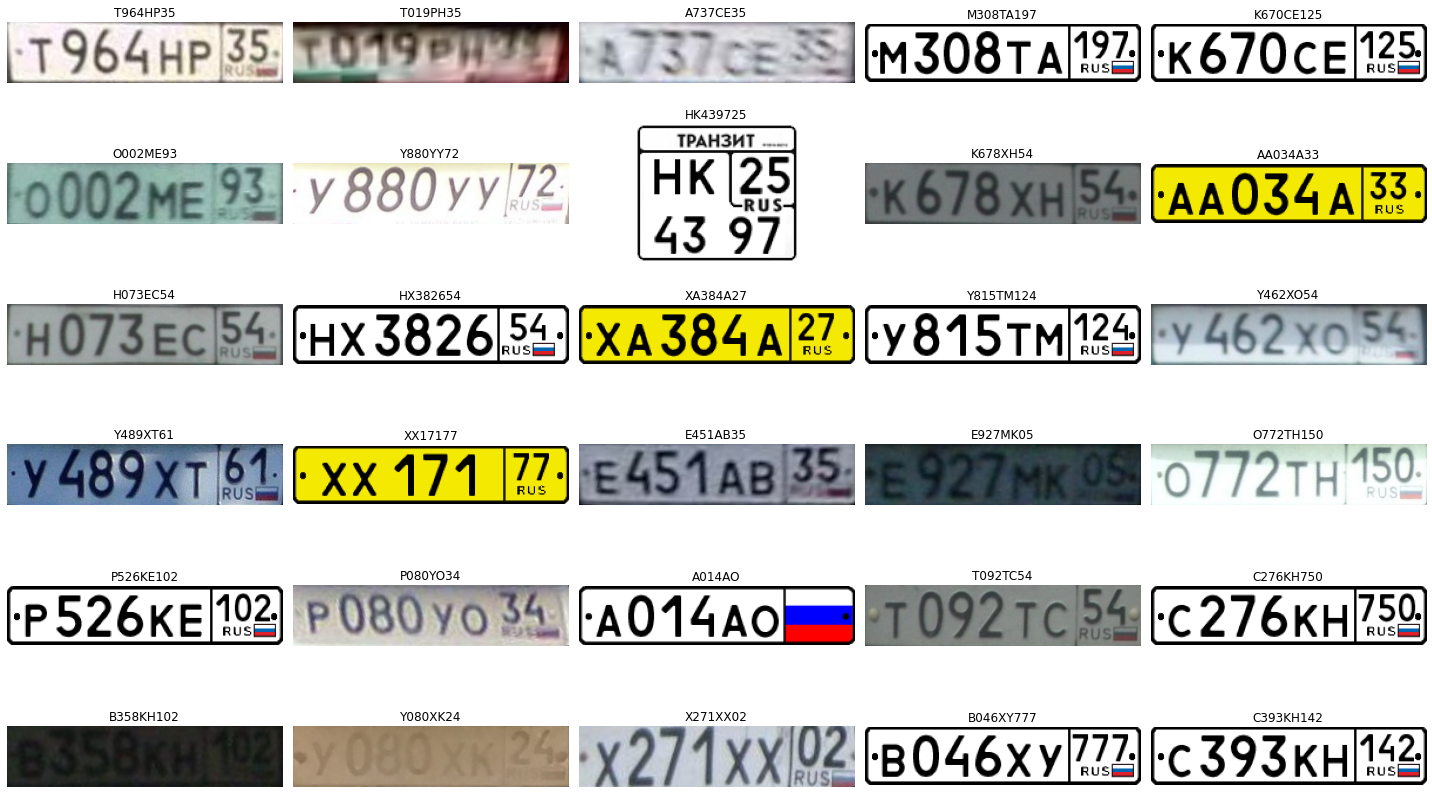

In [5]:
random_idxs = np.random.choice(
    len(config), size=30, replace=False
)
show_tile(config, random_idxs)

In [6]:
abc = "0123456789ABEKMHOPCTYX"  # this is our alphabet for predictions.


In [7]:
def compute_mask(text):
    """Compute letter-digit mask of text, e.g. 'E506EC152' -> 'LDDDLLDDD'.

    Args:
        - text: String of text.

    Returns:
        String of the same length but with every letter replaced by 'L' and every digit replaced by 'D'
        or None if non-letter and non-digit character met in text.
    """
    mask = []

    for char in text:
        if char in digits:
            mask.append("D")
        elif char in ascii_uppercase:
            mask.append("L")
        else:
            return None

    return "".join(mask)


assert compute_mask("E506EC152") == "LDDDLLDDD"
assert compute_mask("E123KX99") == "LDDDLLDD"
assert compute_mask("P@@@KA@@") is None

In [8]:
def check_in_alphabet(text, alphabet=abc):
    """Check if all chars in text come from alphabet.

    Args:
        - text: String of text.
        - alphabet: String of alphabet.

    Returns:
        True if all chars in text are from alphabet and False otherwise.
    """
    for c in text:
        if c not in alphabet:
            return False
    return True


assert check_in_alphabet("E506EC152") is True
assert check_in_alphabet("A123GG999") is False

In [9]:
def filter_data(config):
    """Filter config items keeping only ones with correct text.

    Args:
        - config: List of dicts, each dict having keys "file" and "text".

    Returns:
        Filtered list (config subset).
    """
    config_filtered = []
    for item in tqdm.tqdm(config):
        text = item["text"]
        mask = compute_mask(text)
        if check_in_alphabet(text) and (mask == "LDDDLLDD" or mask == "LDDDLLDDD"):
            config_filtered.append({"file": item["file"], "text": item["text"]})
    return config_filtered

In [10]:
config = filter_data(config)
print("Total items in data after filtering:", len(config))

100%|█████████████████████████████████████████████| 41141/41141 [00:00<00:00, 464730.97it/s]

Total items in data after filtering: 31345


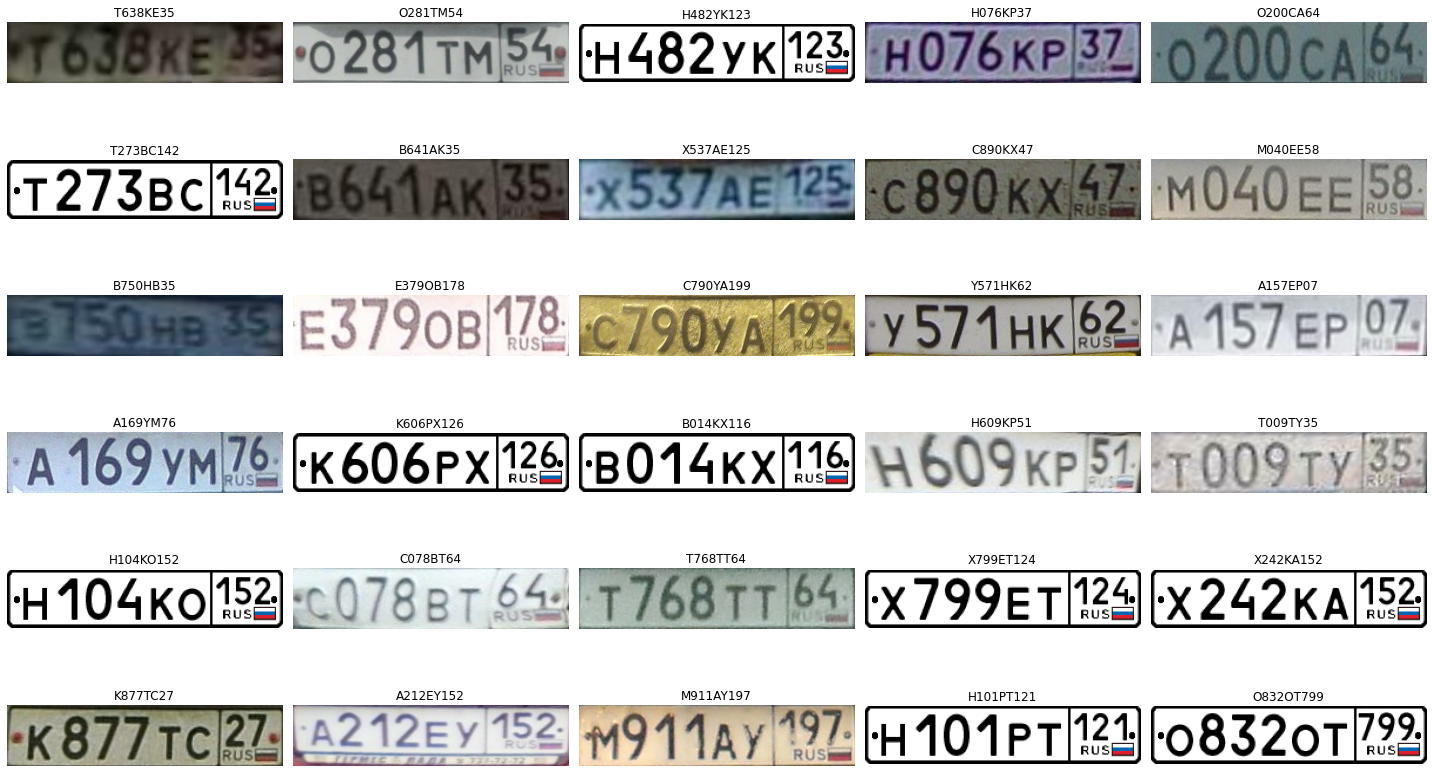

In [11]:
random_idxs = np.random.choice(len(config), size=30, replace=False)
show_tile(config, random_idxs)


In [12]:
class RecognitionDataset(Dataset):
    """Class for training image-to-text mapping using CTC-Loss."""

    def __init__(self, config, alphabet=abc, transforms=None):
        """Constructor for class.

        Args:
            - config: List of items, each of which is a dict with keys "file" & "text".
            - alphabet: String of chars required for predicting.
            - transforms: Transformation for items, should accept and return dict with keys "image", "seq", "seq_len" & "text".
        """
        super(RecognitionDataset, self).__init__()
        self.config = config
        self.alphabet = alphabet
        self.image_names, self.texts = self._parse_root_()
        self.transforms = transforms

    def _parse_root_(self):
        image_names, texts = [], []
        for item in self.config:
            image_name = item["file"]
            text = item["text"]
            texts.append(text)
            image_names.append(image_name)
        return image_names, texts

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, item):
        """Returns dict with keys "image", "seq", "seq_len" & "text".
        Image is a numpy array, float32, [0, 1].
        Seq is list of integers.
        Seq_len is an integer.
        Text is a string.
        """
        image = cv2.imread(self.image_names[item]).astype(np.float32) / 255.0
        text = self.texts[item]
        seq = self.text_to_seq(text)
        seq_len = len(seq)
        output = dict(image=image, seq=seq, seq_len=seq_len, text=text)
        if self.transforms is not None:
            output = self.transforms(output)
        return output

    def text_to_seq(self, text):
        """Encode text to sequence of integers.

        Args:
            - String of text.

        Returns:
            List of integers where each number is index of corresponding characted in alphabet + 1.
        """
        seq = [self.alphabet.find(c) + 1 for c in text]
        return seq


In [13]:
class Resize(object):
    def __init__(self, size=(320, 64)):
        self.size = size

    def __call__(self, item):
        """Apply resizing.

        Args:
            - item: Dict with keys "image", "seq", "seq_len", "text".

        Returns:
            Dict with image resized to self.size.
        """
        item["image"] = cv2.resize(
            item["image"], dsize=self.size, interpolation=cv2.INTER_AREA
        )
        return item


In [14]:
transforms = Resize(size=(320, 64))
dataset = RecognitionDataset(
    config, alphabet=abc, transforms=transforms
)

In [15]:
def collate_fn(batch):
    """Function for torch.utils.data.Dataloader for batch collecting.

    Args:
        - batch: List of dataset __getitem__ return values (dicts).

    Returns:
        Dict with same keys but values are either torch.Tensors of batched images or sequences or so.
    """
    images, seqs, seq_lens, texts = [], [], [], []
    for item in batch:
        images.append(torch.from_numpy(item["image"]).permute(2, 0, 1).float())
        seqs.extend(item["seq"])
        seq_lens.append(item["seq_len"])
        texts.append(item["text"])
    images = torch.stack(images)
    seqs = torch.Tensor(seqs).int()
    seq_lens = torch.Tensor(seq_lens).int()
    batch = {"image": images, "seq": seqs, "seq_len": seq_lens, "text": texts}
    return batch

In [16]:
class FeatureExtractor(Module):
    def __init__(self, input_size=(64, 320), output_len=20):
        super(FeatureExtractor, self).__init__()

        h, w = input_size
        resnet = getattr(models, "resnet18")(pretrained=True)
        self.cnn = Sequential(*list(resnet.children())[:-2])

        self.pool = AvgPool2d(kernel_size=(h // 32, 1))
        self.proj = Conv2d(w // 32, output_len, kernel_size=1)

        self.num_output_features = self.cnn[-1][-1].bn2.num_features

    def apply_projection(self, x):
        """Use convolution to increase width of a features.

        Args:
            - x: Tensor of features (shaped B x C x H x W).

        Returns:
            New tensor of features (shaped B x C x H x W').
        """
        x = x.permute(0, 3, 2, 1).contiguous()
        x = self.proj(x)
        x = x.permute(0, 2, 3, 1).contiguous()

        return x

    def forward(self, x):
        # Apply conv layers
        features = self.cnn(x)

        # Pool to make height == 1
        features = self.pool(features)

        # Apply projection to increase width
        features = self.apply_projection(features)

        return features

In [17]:
class SequencePredictor(Module):
    def __init__(
        self,
        input_size,
        hidden_size,
        num_layers,
        num_classes,
        dropout=0.3,
        bidirectional=False,
    ):
        super(SequencePredictor, self).__init__()

        self.num_classes = num_classes
        self.rnn = GRU(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            dropout=dropout,
            bidirectional=bidirectional,
        )

        fc_in = hidden_size if not bidirectional else 2 * hidden_size
        self.fc = Linear(in_features=fc_in, out_features=num_classes)

    def _init_hidden(self, batch_size):
        """Initialize new tensor of zeroes for RNN hidden state.

        Args:
            - batch_size: Int size of batch

        Returns:
            Tensor of zeros shaped (num_layers * num_directions, batch, hidden_size).
        """
        num_directions = 2 if self.rnn.bidirectional else 1

        h = torch.zeros(
            self.rnn.num_layers * num_directions, batch_size, self.rnn.hidden_size
        )
        return h

    def _reshape_features(self, x):
        """Change dimensions of x to fit RNN expected input.

        Args:
            - x: Tensor x shaped (B x (C=1) x H x W).

        Returns:
            New tensor shaped (W x B x H).
        """
        x = x.squeeze(1).permute(2, 0, 1)
        return x

    def forward(self, x):
        x = self._reshape_features(x)

        batch_size = x.size(1)
        h_0 = self._init_hidden(batch_size)
        h_0 = h_0.to(x.device)
        x, h = self.rnn(x, h_0)

        x = self.fc(x)
        return x

In [18]:
class CRNN(Module):
    def __init__(
        self,
        alphabet=abc,
        cnn_input_size=(64, 320),
        cnn_output_len=20,
        rnn_hidden_size=128,
        rnn_num_layers=2,
        rnn_dropout=0.3,
        rnn_bidirectional=False,
    ):
        super(CRNN, self).__init__()
        self.alphabet = alphabet
        self.features_extractor = FeatureExtractor(
            input_size=cnn_input_size, output_len=cnn_output_len
        )
        self.sequence_predictor = SequencePredictor(
            input_size=self.features_extractor.num_output_features,
            hidden_size=rnn_hidden_size,
            num_layers=rnn_num_layers,
            num_classes=len(alphabet) + 1,
            dropout=rnn_dropout,
            bidirectional=rnn_bidirectional,
        )

    def forward(self, x):
        features = self.features_extractor(x)
        sequence = self.sequence_predictor(features)
        return sequence

In [19]:
def pred_to_string(pred, abc):
    seq = []
    for i in range(len(pred)):
        label = np.argmax(pred[i])
        seq.append(label - 1)
    out = []
    for i in range(len(seq)):
        if len(out) == 0:
            if seq[i] != -1:
                out.append(seq[i])
        else:
            if seq[i] != -1 and seq[i] != seq[i - 1]:
                out.append(seq[i])
    out = "".join([abc[c] for c in out])
    return out


def decode(pred, abc):
    pred = pred.permute(1, 0, 2).cpu().data.numpy()
    outputs = []
    for i in range(len(pred)):
        outputs.append(pred_to_string(pred[i], abc))
    return outputs

In [20]:
feature_extractor = FeatureExtractor()

sequence_predictor = SequencePredictor(
    input_size=512, 
    hidden_size=128, 
    num_layers=2, 
    num_classes=len(abc) + 1
)

/home/ubuntu/anaconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/home/ubuntu/anaconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [21]:

batch_size = 128
num_workers = 2

crnn = CRNN()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
crnn.to(device);
optimizer = torch.optim.Adam(
    crnn.parameters(), lr=3e-4, amsgrad=True, weight_decay=1e-4
)

np.random.shuffle(config)
train_size = int(len(config) * 0.8)
config_train = config[:train_size]
config_val = config[train_size:]

train_dataloader = DataLoader(
    RecognitionDataset(config_train, transforms=Resize()),
    batch_size=batch_size,
    shuffle=True,
    num_workers=num_workers,
    pin_memory=True,
    drop_last=True,
    collate_fn=collate_fn,
)
val_dataloader = DataLoader(
    RecognitionDataset(config_val, transforms=Resize()),
    batch_size=batch_size,
    shuffle=False,
    num_workers=num_workers,
    pin_memory=True,
    drop_last=False,
    collate_fn=collate_fn,
)


# Train loop

In [22]:
from IPython.display import clear_output


In [28]:
num_epochs = 2 if DEBUG else N_EPOCHS

if os.path.exists(PATH_MODEL):
    with open(PATH_MODEL, "rb") as fp:
        state_dict = torch.load(fp, map_location="cpu")
    crnn.load_state_dict(state_dict)

loss_history = dict(train=[], val=[], train_b=[], val_b=[])
for i, epoch in enumerate(range(num_epochs)):
    
    ########### TRAIN #############
    train_losses = []
    crnn.train()
    for j, b in enumerate(train_dataloader):
        images = b["image"].to(device)
        seqs_gt, seq_lens_gt = b["seq"], b["seq_len"]
        seqs_pred = crnn(images).cpu()
        seq_lens_pred = torch.Tensor([seqs_pred.size(0)] * seqs_pred.size(1)).int()
        loss = ctc_loss(
            log_probs=log_softmax(seqs_pred, dim=2),  # (T, N, C)
            targets=seqs_gt,  # N, S or sum(target_lengths)
            input_lengths=seq_lens_pred,  # N
            target_lengths=seq_lens_gt,
        )  # N
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_losses.append(loss.item())
        loss_history["train_b"].append(np.mean(train_losses))
        clear_output()
        print(f"epoch={i}/{num_epochs} batch={j}/{len(train_dataloader)} train_loss={np.mean(train_losses)}")
        if DEBUG and j > 10:
            break
    loss_history["train"].append(np.mean(train_losses))
    ############## VAL ##############
    crnn.eval()
    val_losses = []
    for j, b in enumerate(val_dataloader):
        images = b["image"].to(device)
        seqs_gt, seq_lens_gt = b["seq"], b["seq_len"]
        with torch.no_grad():
            seqs_pred = crnn(images).cpu()
        seq_lens_pred = torch.Tensor([seqs_pred.size(0)] * seqs_pred.size(1)).int()
        loss = ctc_loss(
            log_probs=log_softmax(seqs_pred, dim=2),  # (T, N, C)
            targets=seqs_gt,  # N, S or sum(target_lengths)
            input_lengths=seq_lens_pred,  # N
            target_lengths=seq_lens_gt,  # N
        )
        val_losses.append(loss.item())
        loss_history["train_b"].append(np.mean(val_losses))
        clear_output()
        print(f"epoch={i}/{num_epochs} batch={j}/{len(val_dataloader)} val_loss={np.mean(val_losses)}")
        if DEBUG and j > 10:
            break
    loss_history["val"].append(np.mean(val_losses))

    ########### EPOCH RESULT ############
    for j, train_loss, val_loss in enumerate(zip(
        loss_history["train"], loss_history["val"]
    )):
        print(
            f"epoch {j} finished: "
            f"train_loss={np.mean(train_loss)} "
            f"val_loss={np.mean(val_loss)}"
        )
    print()
    torch.save(crnn.state_dict(), PATH_MODEL)


epoch=1/2 batch=11/49 val_loss=2.5313765605290732
epoch 1 finished: train_loss=2.6801158587137857 val_loss=2.6194671392440796
epoch 1 finished: train_loss=2.5689969261487327 val_loss=2.5313765605290732



In [ ]:
y_ticks = ["-"] + [x for x in abc]

images = b["image"]
seqs_gt = b["seq"]
seq_lens_gt = b["seq_len"]
texts = b["text"]

preds = crnn(images.to(device)).cpu().detach()
texts_pred = decode(preds, crnn.alphabet)

for i in range(10):
    plt.figure(figsize=(15, 5))
    pred_i = preds[:, i, :].T

    plt.subplot(1, 2, 1)
    image = images[i].permute(1, 2, 0).numpy()
    plt.imshow(image)
    plt.axis("off")
    plt.title(texts[i])

    plt.subplot(1, 2, 2)
    plt.yticks(range(pred_i.size(0)), y_ticks)
    plt.imshow(pred_i)
    plt.title(texts_pred[i])

    plt.show()